In this notebook, I want to assess the accuracy of the trained model.
This is done by evaluating the energy of configurations in the training/test set.
The predicted energies are compared to the DFT calculated energies in a parity plot.

Additionally, I also want to look at the uncertainty of the energy predictions, evaluated using different member in the ensemble.

In [1]:
from pathlib import Path
import json
import os
import re
import pickle
from tqdm import tqdm
from multiprocessing import Pool
import sys

import numpy as np
import matplotlib.pyplot as plt

from ase.io import read, iread
from ase.calculators.kim import KIM

%matplotlib inline
plt.style.use("default")

In [2]:
# Read settings
WORK_DIR = Path().absolute()
ROOT_DIR = WORK_DIR.parent
SETTINGS_DIR = ROOT_DIR / "settings"

settings_path = SETTINGS_DIR / "settings0_test.json"
with open(settings_path, "r") as f:
    settings = json.load(f)

RES_DIR = WORK_DIR / "results" / re.match(r"^[^_\.]+", settings_path.name).group()
if not RES_DIR.exists():
    RES_DIR.mkdir(parents=True)
PLOT_DIR = RES_DIR / "plots"
if not PLOT_DIR.exists():
    PLOT_DIR.mkdir(parents=True)

# Get the reference and predicted energy

In [3]:
# Which data partition to use: "test" or "training"
mode = "test" if "test" in settings_path.name else "training"
uncertainty_energy_forces_file = RES_DIR / f"uncertainty_energy_forces_{mode}.pkl"

if uncertainty_energy_forces_file.exists():
    with open(uncertainty_energy_forces_file, "rb") as f:
        configs_dict = pickle.load(f)
    structures = list(configs_dict)
else:
    # Get all configurations
    configs_dict = {}

    dataset_dir = Path(settings["dataset"]["dataset_path"])
    structures = os.listdir(dataset_dir)
    for struct in structures:
        substructures = os.listdir(dataset_dir / struct)
        configs_dict.update({struct: {"identifier": []}})

        for substruct in substructures:
            subdir = dataset_dir / struct / substruct
            if os.path.isdir(subdir / os.listdir(subdir)[0]):
                # The configurations are stored inside the subsubdirectory
                subsubstructures = os.listdir(subdir)
                for subsubstruct in subsubstructures:
                    configs = os.listdir(subdir / subsubstruct)
                    configs_paths = [str(subdir / subsubstruct / cc) for cc in configs]
                    configs_dict[struct]["identifier"].extend(configs_paths)
            else:
                # The configurations are stored inside the subdirectory
                configs = os.listdir(subdir)
                configs_paths = [str(subdir / cc) for cc in configs]
                configs_dict[struct]["identifier"].extend(configs_paths)

    # Get the reference data and predictions
    for struct in structures:
        identifiers = configs_dict[struct].pop("identifier")
        nid = len(identifiers)
        for ii, path in tqdm(enumerate(identifiers), desc=struct, total=nid):
            atoms = read(path)
            # Reference values
            ref_energy = atoms.info["Energy"]
            ref_forces = atoms.todict()["force"]
            natoms = atoms.get_global_number_of_atoms()

            # Predictions ensembles, use parallel computing
            def compute_energy_forces_member(set_idx):
                # Potential member
                atoms_member = atoms.copy()
                atoms_member.calc = KIM(f"DUNN_C_losstraj_{set_idx:03d}")
                # Predictions
                energy = atoms_member.get_potential_energy()
                forces = atoms_member.get_forces()
                return [energy, forces]

            with Pool(25) as p:
                energy_forces_preds = list(
                    tqdm(p.imap(compute_energy_forces_member, range(100)), total=100)
                )

            # Convert the ensembles to np.array
            energy_ensembles = np.array([member[0] for member in energy_forces_preds])
            forces_ensembles = np.array([member[1] for member in energy_forces_preds])

            configs_dict[struct].update(
                {
                    Path(path).name: {
                        "identifier": path,
                        "natoms": natoms,
                        "energy": ref_energy,
                        "forces": ref_forces,
                        "energy_ensembles": energy_ensembles,
                        "forces_ensembles": forces_ensembles,
                    }
                }
            )

            with open(uncertainty_energy_forces_file, "wb") as f:
                pickle.dump(configs_dict, f, protocol=4)

## Parse data for plotting

In [4]:
energy_dict = {struct: {} for struct in structures}
forces_dict = {struct: {} for struct in structures}

In [5]:
for struct in structures:
    energy_ref = np.array([val["energy"] for val in configs_dict[struct].values()])
    natoms = np.array([val["natoms"] for val in configs_dict[struct].values()])
    energy_ens = np.array(
        [val["energy_ensembles"] for val in configs_dict[struct].values()]
    )
    energy_mean = np.mean(energy_ens, axis=1)
    energy_std = np.std(energy_ens, axis=1)
    energy_dict[struct].update(
        {
            "reference": energy_ref,
            "natoms": natoms,
            "ensembles": energy_ens,
        }
    )

In [6]:
for struct in structures:
    forces_ref = np.empty((0, 3))
    forces_ens = np.empty((100, 0, 3))
    for val in configs_dict[struct].values():
        # Reference
        forces_ref = np.concatenate((forces_ref, val["forces"]), axis=0)
        # Predictions
        forces_ens = np.concatenate((forces_ens, val["forces_ensembles"]), axis=1)

    # Magnitude of forces
    forces_ref = np.concatenate(
        (forces_ref, np.linalg.norm(forces_ref, axis=-1).reshape((-1, 1))), axis=-1
    )
    forces_ens = np.concatenate(
        (forces_ens, np.linalg.norm(forces_ens, axis=-1).reshape((100, -1, 1))), axis=-1
    )
    # Statistics
    forces_mean = np.mean(forces_ens, axis=0)
    forces_std = np.std(forces_ens, axis=0)
    forces_dict[struct].update(
        {
            "reference": forces_ref,
            "ensembles": forces_ens,
        }
    )

# Plot

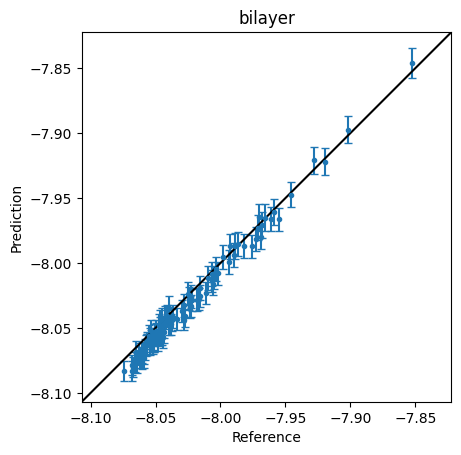

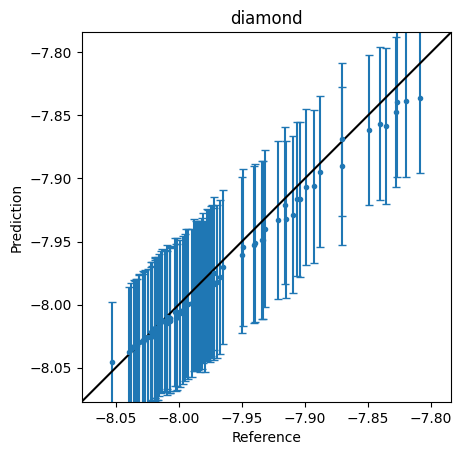

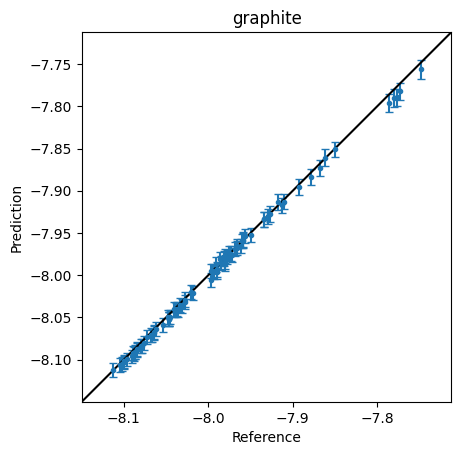

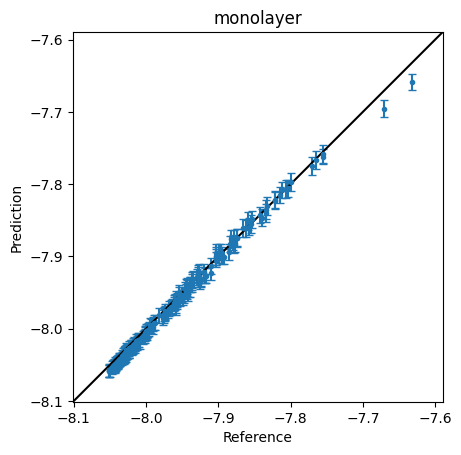

In [7]:
# Energy parity plot each structure separately
for structure in structures:
    # Get the data
    natoms = energy_dict[structure]["natoms"]
    ref_eng = energy_dict[structure]["reference"] / natoms
    ens_eng = energy_dict[structure]["ensembles"] / natoms.reshape((-1, 1))
    ens_eng_mean = np.mean(ens_eng, axis=1)
    ens_eng_std = np.std(ens_eng, axis=1)

    # Some plotting constants
    xdata = ref_eng
    ydata = ens_eng_mean
    eng_max = np.max([xdata, ydata])
    eng_min = np.min([xdata, ydata])
    eng_range = eng_max - eng_min
    axis_min = eng_min - 0.1 * eng_range
    axis_max = eng_max + 0.1 * eng_range

    # Plot
    plt.figure()
    plt.title(structure)
    plt.errorbar(xdata, ydata, ens_eng_std, fmt=".", capsize=3)
    plt.plot([axis_min, axis_max], [axis_min, axis_max], c="k")
    plt.xlim(axis_min, axis_max)
    plt.ylim(axis_min, axis_max)
    plt.xlabel("Reference")
    plt.ylabel("Prediction")
    plt.gca().set_aspect("equal")
plt.show()

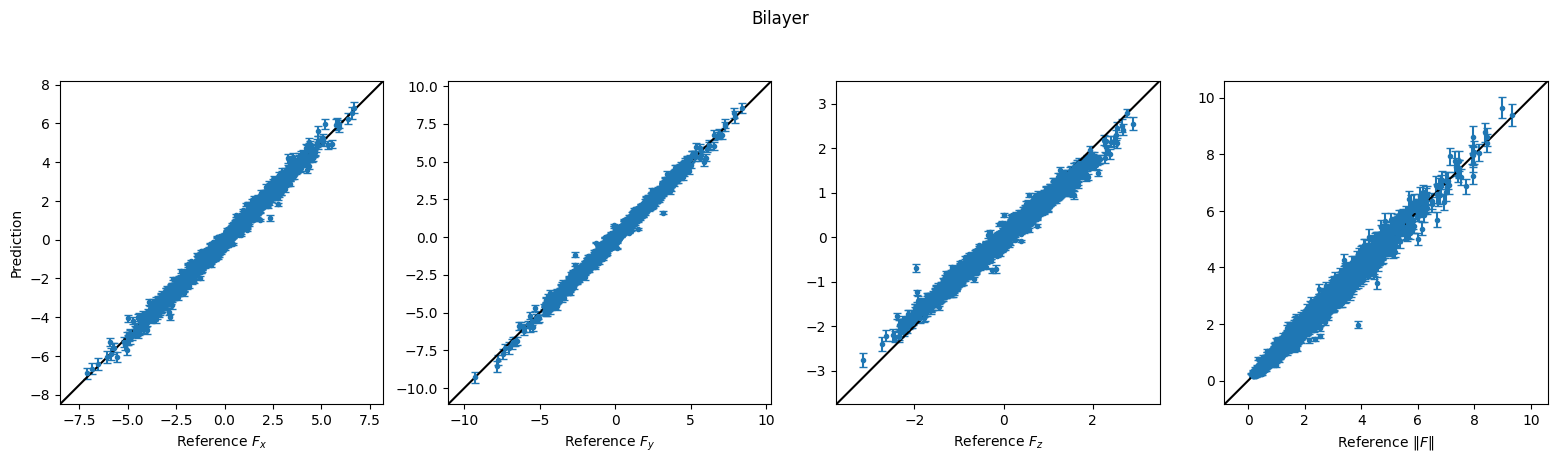

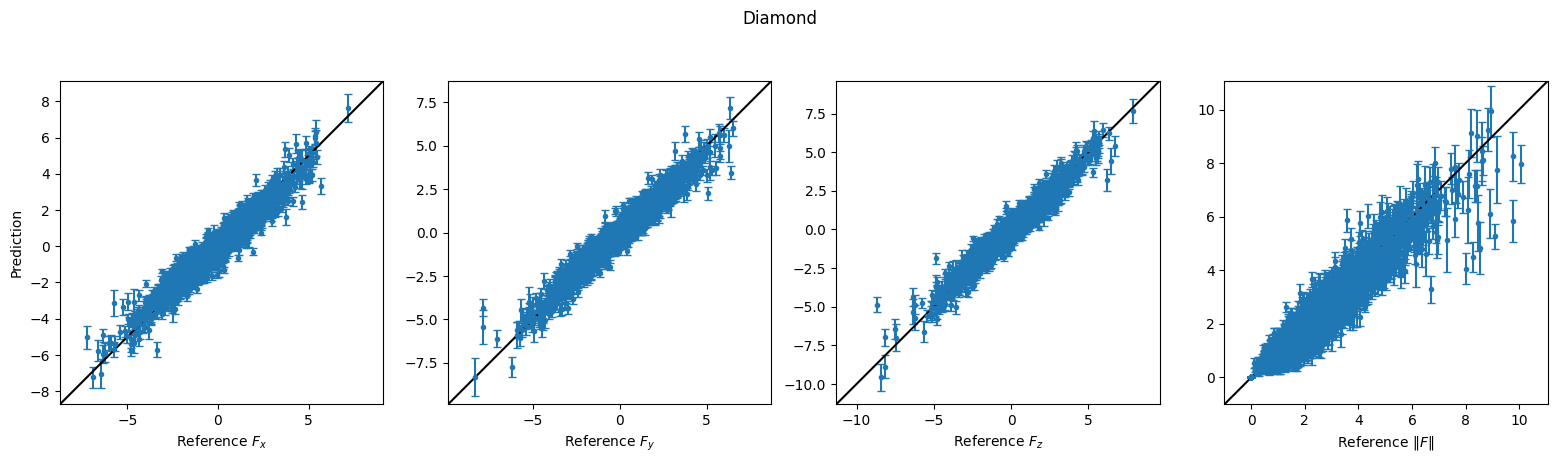

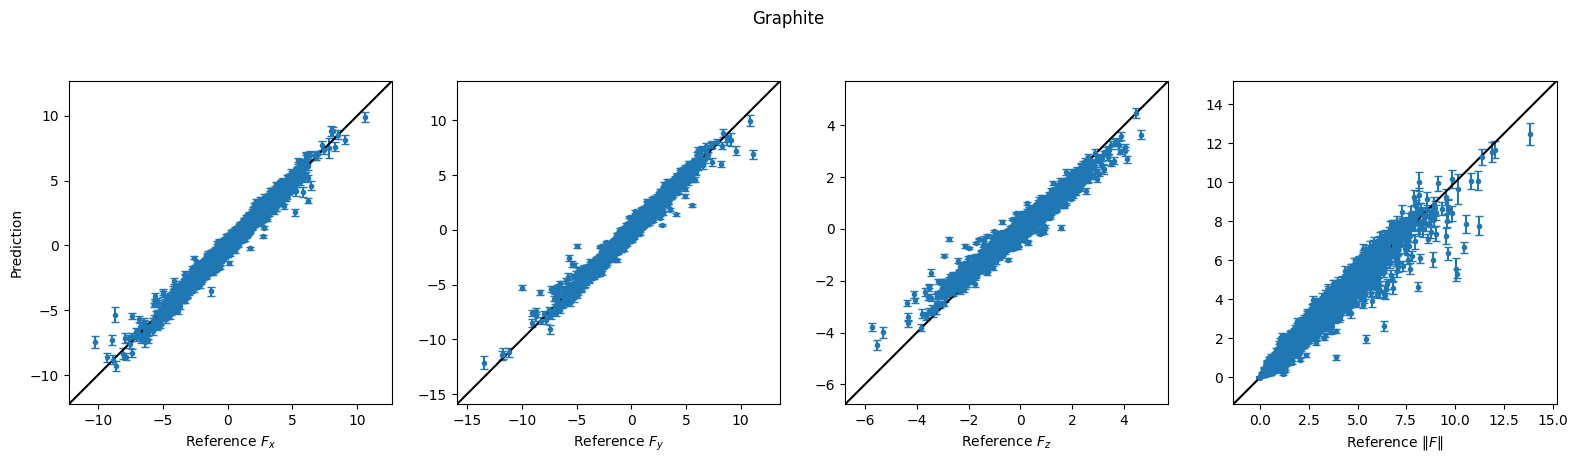

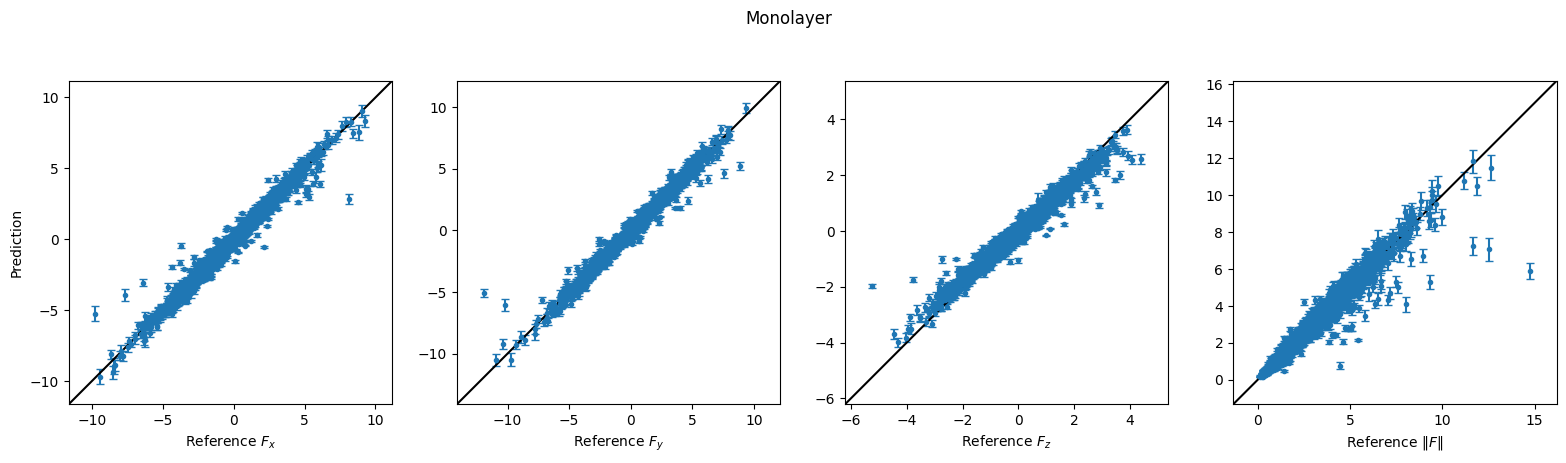

In [8]:
# forces parity plot each structure separately
for structure in structures:
    # Get the data
    ref_for = forces_dict[structure]["reference"]
    ens_for = forces_dict[structure]["ensembles"]
    ens_for_mean = np.mean(ens_for, axis=0)
    ens_for_err = np.std(ens_for, axis=0)

    # Plot
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(4 * 4.8, 4.8))
    fig.suptitle(structure.capitalize())
    xlabel_list = [
        r"Reference $F_x$",
        r"Reference $F_y$",
        r"Reference $F_z$",
        r"Reference $\Vert F \Vert$",
    ]
    for ii in range(4):
        ax = axes[ii]
        # Some plotting constants
        xdata = ref_for[:, ii]
        ydata = ens_for_mean[:, ii]
        for_max = np.max([xdata, ydata])
        for_min = np.min([xdata, ydata])
        for_range = for_max - for_min
        axis_min = for_min - 0.1 * for_range
        axis_max = for_max + 0.1 * for_range

        ax.errorbar(xdata, ydata, ens_for_err[:, ii], fmt=".", capsize=3)
        ax.plot([axis_min, axis_max], [axis_min, axis_max], c="k")
        ax.set_xlim(axis_min, axis_max)
        ax.set_ylim(axis_min, axis_max)

        # Labels
        ax.set_xlabel(xlabel_list[ii])
        if ii == 0:
            ax.set_ylabel("Prediction")
        ax.set_aspect("equal")
plt.show()

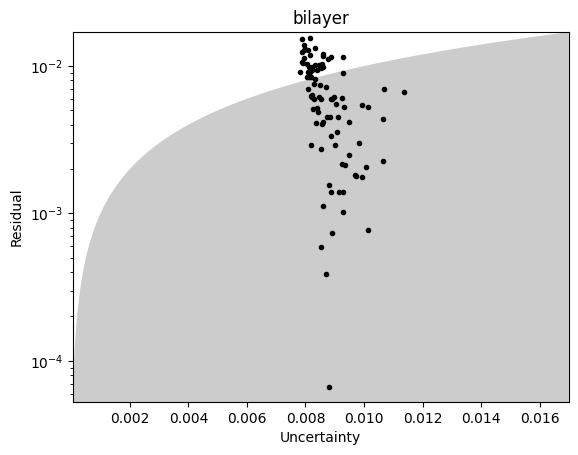

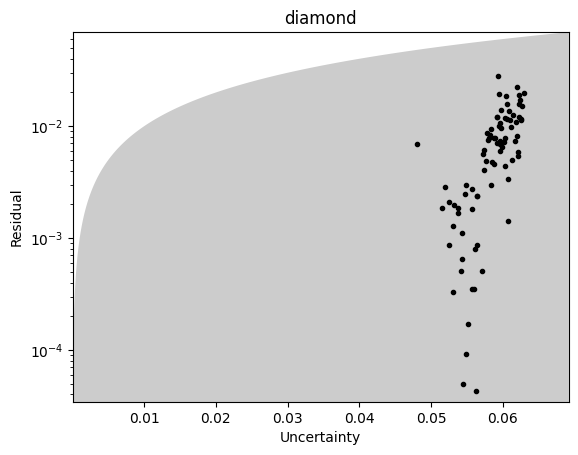

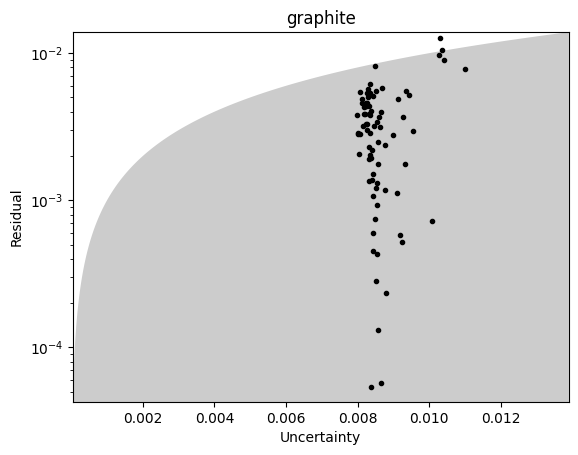

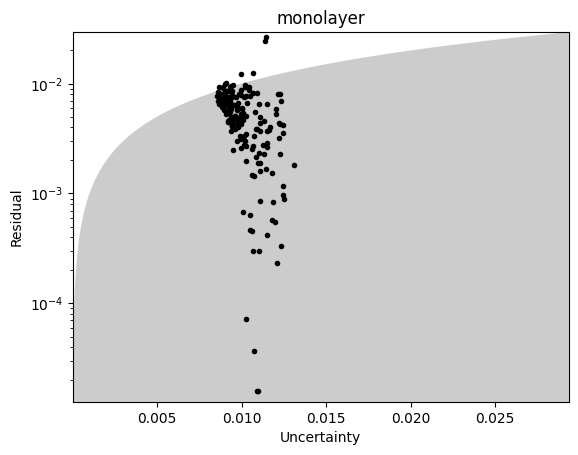

In [9]:
# Plot Residual vs uncertainty for Energy
for structure in structures:
    # Get the data
    natoms = energy_dict[structure]["natoms"]
    ref_eng = energy_dict[structure]["reference"] / natoms
    ens_eng = energy_dict[structure]["ensembles"] / natoms.reshape((-1, 1))
    ens_eng_mean = np.mean(ens_eng, axis=1)
    ens_eng_std = np.std(ens_eng, axis=1)
    eng_residual = np.abs(ref_eng - ens_eng_mean)
    
    # Some plotting constants
    ax_max = max([max(eng_residual), max(ens_eng_std)])
    ax_min = min([min(eng_residual), min(ens_eng_std)])
    ax_range = ax_max - ax_min
    axis_min = ax_min * 0.8
    axis_max = ax_max + 0.1 * ax_range
    xfine = np.logspace(np.log10(axis_min), np.log10(axis_max), 1000)
    
    # Plot
    plt.figure()
    plt.title(structure)
    plt.plot(ens_eng_std, eng_residual, ".", c="k")
    plt.fill_between(xfine, xfine, alpha=0.2, color="k", lw=0)
    # plt.xscale("log")
    plt.yscale("log")
    plt.xlim(axis_min, axis_max)
    plt.ylim(axis_min, axis_max)
    plt.xlabel("Uncertainty")
    plt.ylabel("Residual")
    # plt.gca().set_aspect("equal")
plt.show()

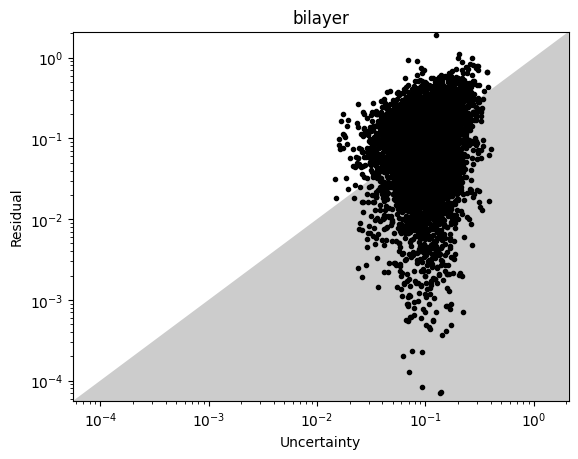

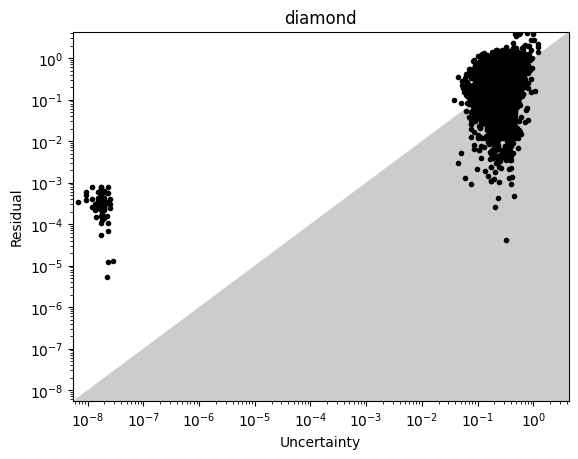

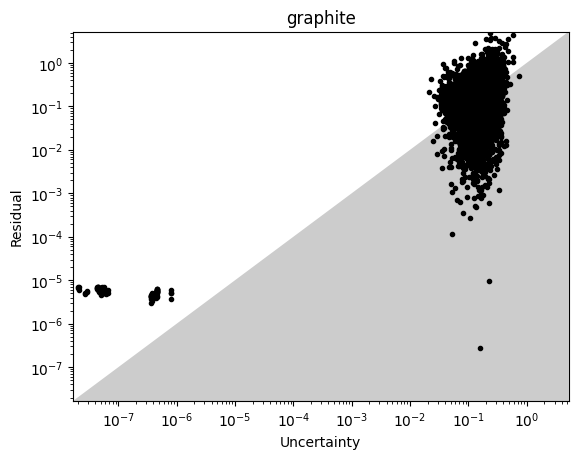

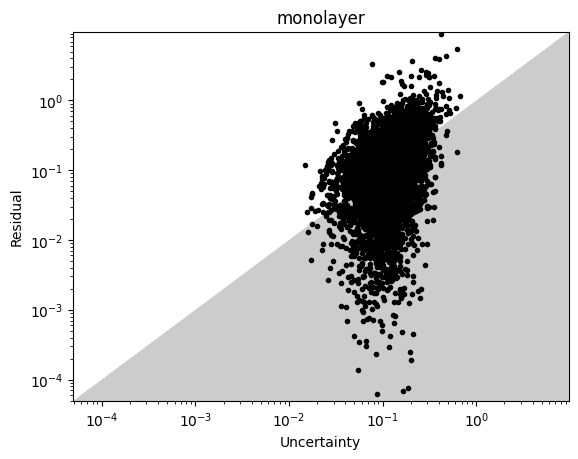

In [10]:
# Plot Residual vs uncertainty for Forces
for structure in structures:
    # Get the data
    ref_for = forces_dict[structure]["reference"][:, -1]
    ens_for = forces_dict[structure]["ensembles"]
    ens_for_mean = np.mean(ens_for, axis=0)[:, -1]
    ens_for_std = np.std(ens_for, axis=0)[:, -1]
    for_residual = np.abs(ref_for - ens_for_mean)

    # Plot
    # Some plotting constants
    ax_max = max([max(for_residual), max(ens_for_std)])
    ax_min = min([min(for_residual), min(ens_for_std)])
    ax_range = ax_max - ax_min
    axis_min = ax_min * 0.8
    axis_max = ax_max + 0.1 * ax_range
    xfine = np.logspace(np.log10(axis_min), np.log10(axis_max), 1000)
    
    # Plot
    plt.figure()
    plt.title(structure)
    plt.plot(ens_for_std, for_residual, ".", c="k")
    plt.fill_between(xfine, xfine, alpha=0.2, color="k", lw=0)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(axis_min, axis_max)
    plt.ylim(axis_min, axis_max)
    plt.xlabel("Uncertainty")
    plt.ylabel("Residual")
    # plt.gca().set_aspect("equal")
plt.show()